## ***Defining Utilities***

In [ ]:
#standard imports for image processing

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.autonotebook import tqdm
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [ ]:
#defining some utils for processing

plt.rcParams["figure.figsize"] = (5,10)
plt.rcParams["figure.edgecolor"] = "black"
plt.rcParams["lines.linewidth"] = 1

def scale(a,sf=255,delta=0):
    if np.max(a)==np.min(a)==0: return a
    return ((a - np.min(a)+delta) * (sf / (np.abs(np.min(a)) + np.abs(np.max(a)+delta)))).astype(np.uint8)

def plot(img,title=""):
    plt.imshow(img,cmap='gray',vmin=0,vmax=255)
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    print("Size :",img.shape)
    print("dtype :",img.dtype)
    print("max:",np.max(img)," min:",np.min(img))

def plot_color(img,title=""):
    plt.imshow(img,vmin=0,vmax=255)
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    print("Size :",img.shape)
    print("dtype :",img.dtype)
    print("max:",np.max(img)," min:",np.min(img))
  
def plot_mult(img,title):
    plt.imshow(img,cmap='gray',vmin=0,vmax=255)
    plt.axis('off')
    plt.title(title)
    

# **Q1**


##a) Load 'headCT.tif' **[0 Points]**

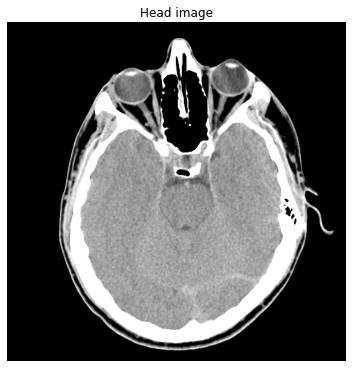

Size : (512, 512)
dtype : uint8
max: 255  min: 0


In [ ]:
headCT = cv2.imread('headCT.tif',cv2.IMREAD_GRAYSCALE)
plot(headCT,"Head image")

a = headCT

##b) Blur a) using cv.GaussianBlur() with $19\times 19$ filter having $\sigma=2$  **[5 Points]**

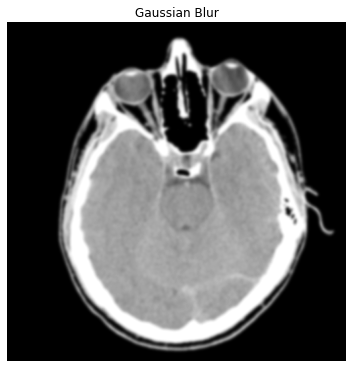

Size : (512, 512)
dtype : uint8
max: 255  min: 0


In [ ]:
headCTBlur = cv2.GaussianBlur(a,ksize=(19,19),sigmaX=2)
plot(headCTBlur,"Gaussian Blur")

b = headCTBlur

##c) Apply laplacian to b) using cv.Laplacian() with $ksize = 1$   **[5 Points]**

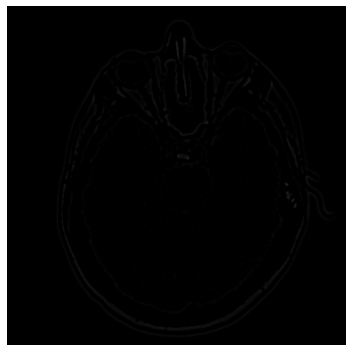

Size : (512, 512)
dtype : int16
max: 41  min: -36


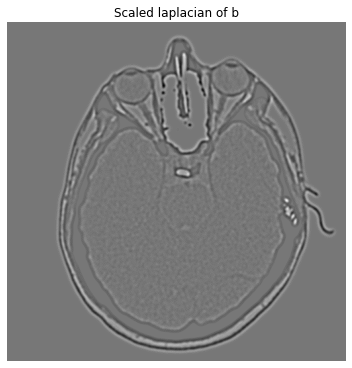

Size : (512, 512)
dtype : uint8
max: 255  min: 0


In [ ]:
headLaplacian = b.astype(np.int16)
headLaplacian = cv2.Laplacian(headLaplacian,ddepth=-1,ksize=1)

c = scale(headLaplacian)
plot(headLaplacian)
plot(c,"Scaled laplacian of b")

##d) Implement zero-crossing of Marr-Hildreth edge detector. Tune and report threshold value for final output. Display Final output. **[30 Points]**

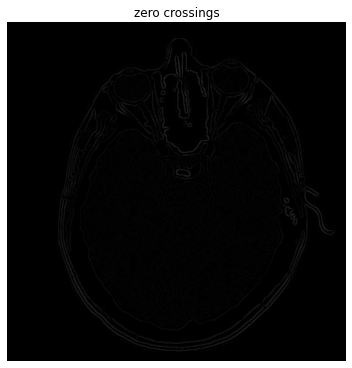

Size : (512, 512)
dtype : int16
max: 45  min: 0
77


In [ ]:
laplacian_16S = headLaplacian
tv = np.max(laplacian_16S) - np.min(laplacian_16S)
#let zero crossings be zc array
zc = np.zeros_like(laplacian_16S)
  
def zerolap(x1,y1,x2,y2):
  global laplacian_16S
  return np.abs(laplacian_16S[x1][y1])+np.abs(laplacian_16S[x2][y2]) if (np.sign(laplacian_16S[x1][y1])*np.sign(laplacian_16S[x2][y2])==-1) else 0
  

def sum(*args):
  s = 0
  for i in range(len(args)):
    s += args[i]
  return s

#generating zero crossings in the LOG found before
for i in range(1,laplacian_16S.shape[0]-1):
    for j in range(1,laplacian_16S.shape[1]-1):
      zc[i][j] = max(zerolap(i-1,j,i+1,j),zerolap(i,j-1,i,j+1),zerolap(i-1,j-1,i+1,j+1),zerolap(i+1,j-1,i-1,j+1))

scaled_zc = scale(zc)
plot(zc,'zero crossings')
print(tv)

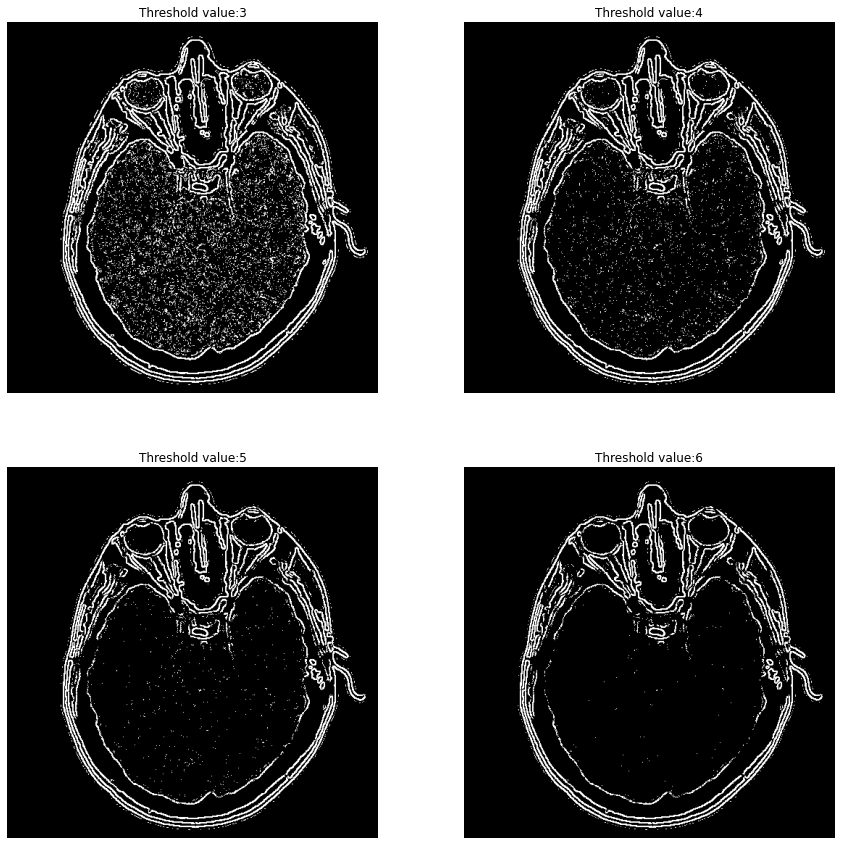

In [ ]:
#thresholding the image with different values
thresh = []
scaled_thresh = []
tv_start = int(tv*0.05)
for i in range(1,5):
  _,thresh_zc = cv2.threshold(zc,tv_start+i,255,cv2.THRESH_BINARY)
  thresh.append(thresh_zc)
  scaled_thresh.append(scale(thresh_zc))                                         #scaling the resultant image to display

#ploting the results
plt.rcParams["figure.figsize"] = (15,15)

plt.subplot(2,2,1)
plot_mult(scaled_thresh[0],'Threshold value:'+str(tv_start + 0))

plt.subplot(2,2,2)
plot_mult(scaled_thresh[1],'Threshold value:'+str(tv_start + 1))

plt.subplot(2,2,3)
plot_mult(scaled_thresh[2],'Threshold value:'+str(tv_start + 2))

plt.subplot(2,2,4)
plot_mult(scaled_thresh[3],'Threshold value:'+str(tv_start + 3))

plt.rcParams["figure.figsize"] = (5,10)


A good threshold value would be 5 or 6 since the noise is conciderably reduced.


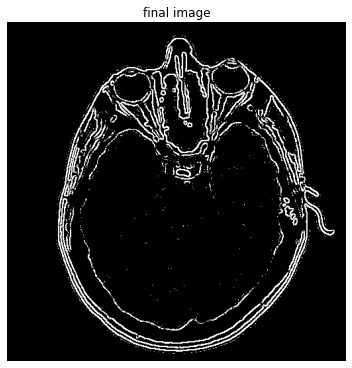

Size : (512, 512)
dtype : uint8
max: 255  min: 0


In [ ]:
print('A good threshold value would be 5 or 6 since the noise is conciderably reduced.')
plot(scaled_thresh[3],'final image')


##e) Explain drawbacks of Marr-Hildreth edge detector with respect to given image and final output. **[10 Points]**

The key benefit of Marr-Hildreth has been proven in a larger region surrounding the pixels.
As a result, finding the correct locations for edges appears to be very easy, which is also MHD's most significant advantage.
For Marr's edge detection, the Laplacian of Gaussian (LoG) operator employs the Laplacian filter.

Disadvantages:

*   The downside is that it limits precision in determining edge orientation and malfunctions at corners and curves, where the grey level intensity function differs.
*   The downside is the noise sensitivity. The noise introduced by detecting the edges and their orientations in the picture would gradually degrade the magnitude of the edges. The second drawback is that some of the current edges in the noisy image distort the operation.

Conclusion:
  On comparing the original image with final image the edges obtained are visible but kind of noisy since at the final step we threshold the filtered image and that is not sure to remove the noise in the image.



# **Q2) Implement mean shift for filtering and segmentation of a color image.** 
##**[50 points]**

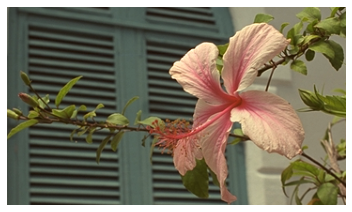

Size : (211, 361, 3)
dtype : uint8
max: 255  min: 0


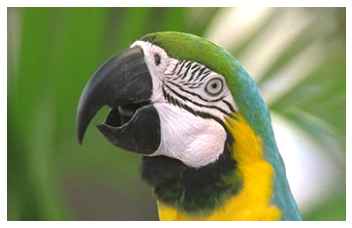

Size : (221, 350, 3)
dtype : uint8
max: 255  min: 0


In [ ]:
flower = cv2.imread('flower.png')
flower = cv2.cvtColor(flower,cv2.COLOR_BGR2RGB)

parrot = cv2.imread('parrot.png')
parrot = cv2.cvtColor(parrot,cv2.COLOR_BGR2RGB)

plot_color(flower)
plot_color(parrot)

In [ ]:
def get_rand(start, end):
    a = list(range(start, end))
    np.random.shuffle(a)
    return a


def arr(*args):
    a = []
    for i in args:
        a.append(i)
    return np.array(a).astype(int)

class ImageProcessor:
    def __init__(self, image):
        self.image = image
        self.output_cluster = image.copy()
        self.filtered = image.copy()
        self.shape = image.shape

    @classmethod
    def get_dists(cls, points, point):
        return np.sum(np.square(points - point), axis=1)

    @classmethod
    def get_dist(cls, point1, point2):
        return np.linalg.norm(point2 - point1)
    
    def cluster(self, k, ITER_LIM):
        img = self.filtered.copy()
        output = img.copy()
        shape = img.shape
        features = np.zeros((shape[0] * shape[1], 5))
        for i in range(shape[0]):
            for j in range(shape[1]):
                temp = img[i][j]
                features[i * shape[1] + j] = arr(i, j, temp[0], temp[1], temp[2])

        np.random.shuffle(features)

        clusters = (features[:k]).copy()
        # points = np.array([int(k * np.random.randint()) for _ in range(features.shape[0])])
        points = np.random.randint(k, size=features.shape[0])
        for cl_ix in range(k):
            points[cl_ix] = cl_ix

        converged = False
        iteration = 0

        while not converged:
            sys.stdout.write('\r' + 'Iteration ' + str(iteration))
            points_cpy = points.copy()

            for ftr_idx in range(features.shape[0]):
                ar = ImageProcessor.get_dists(features[ftr_idx], clusters)
                points[ftr_idx] = np.argmin(ar)

            if (points_cpy == points).all() or iteration > ITER_LIM:
                converged = True

            for cl_idx in range(k):
                barr_clstr = (points == cl_idx)
                nz_ftr_cnt = np.sum(barr_clstr)
                clstr_fts = barr_clstr[..., np.newaxis] * features
                clusters[cl_idx] = (np.sum(clstr_fts, axis=0) / nz_ftr_cnt).astype(int)
            iteration += 1

        for ft_id in range(features.shape[0]):
            cid = int(points[ft_id])
            ftr = features[ft_id].astype(int)
           # if ((shape[:2] - ftr[:2]) > 0).all():
            output[ftr[0]][ftr[1]] = clusters[cid][2:5]

        self.output_cluster = output
        print('\nLabels : ', points)

    def filter(self, SIGMA_SP, SIGMA_RGB, N, ITER,IMG_UPD_SIZE):
        for _ in range(ITER):
            print('Iteration ', _, ':')
            self.run(SIGMA_SP, SIGMA_RGB, N,IMG_UPD_SIZE)

    def run(self, SIGMA_SP, SIGMA_RGB, N,IMG_UPD_SIZE):
        img = self.filtered.copy()
        shape = self.shape
        output = self.output_cluster
        features = np.zeros((shape[0], shape[1], 5))

        for i in range(shape[0]):
            for j in range(shape[1]):
                temp = img[i][j]
                features[i][j] = arr(i, j, temp[0], temp[1], temp[2])

        eta = 1
        w_size = N
        w_size_2 = int(N / 2)
        w_img_upd = IMG_UPD_SIZE
        w_img_upd_2 = int(w_img_upd/2)
        with tqdm(total=(shape[0] - 2 * w_size_2) * (shape[1] - 2 * w_size_2)) as progress:
            r_px, r_py = get_rand(w_size_2, shape[0] - w_size_2), get_rand(w_size_2, shape[1] - w_size_2)
            avg_steps = conv_count = div_count = 0

            for px in r_px:
                for py in r_py:
                    converged = False
                    cluster_center = features[px][py]
                    steps = 0
                    while not converged:
                        prev_center = cluster_center.copy()

                        win_features = features[px - w_size_2:px + w_size_2 + 1, py - w_size_2:py + w_size_2 + 1, :]
                        win_ft_diff = win_features - cluster_center
                        win_ft_diff_sq = np.square(win_ft_diff)

                        win_ft_sp = np.sum(win_ft_diff_sq[:, :, :2], axis=2)
                        win_ft_rgb = np.sum(win_ft_diff_sq[:, :, 2:5], axis=2)

                        sp_wts = np.exp(-1 * win_ft_sp / (2 * (SIGMA_SP ** 2)))
                        rgb_wts = np.exp(-1 * win_ft_rgb / (2 * (SIGMA_RGB ** 2)))

                        wts = np.multiply(sp_wts, rgb_wts)
                        mean_shift = (wts[..., np.newaxis] * win_features) / np.sum(wts)
                        mean_shift = np.sum(mean_shift.reshape((w_size * w_size, 5)), axis=0)
                        cluster_center = mean_shift.astype(int)
                        # print(cluster_center,end='')
                        steps += 1

                        if np.linalg.norm(cluster_center - prev_center) < eta or steps > 50:
                            converged = True
                            output[px][py] = cluster_center[2:5]
                            temp = cluster_center[2:5]
                            # features[px][py] = arr(px, py, temp[0], temp[1], temp[2])
                            temp = features[px-w_img_upd_2:px+w_img_upd_2+1,py-w_img_upd_2:py+w_img_upd_2+1,2:5].reshape((w_img_upd*w_img_upd,3))
                            avg_color = np.sum(temp, axis=0) / (w_img_upd * w_img_upd)

                            features[px][py] = arr(px,py,avg_color[0],avg_color[1],avg_color[2])

                            if steps > 50:
                                div_count += 1
                            else:
                                conv_count += 1
                                avg_steps += steps

                    progress.update(1)
        print('converged:', conv_count, ' diverged:', div_count, ' average_shifts:', avg_steps / conv_count)
        output = output[w_size_2:shape[0]-w_size_2,w_size_2:shape[1]-w_size_2]
        self.output_cluster = output
        self.filtered = output


In [ ]:
## PARAMS ##
SIGMA_SP = 10
SIGMA_RGB = 19
BAND_SIZE = 23
ITER = 1
IMG_UPD_SIZE = 1
## END PARAMS ##

Iteration  0 :



converged: 63925  diverged: 146  average_shifts: 8.051810715682441


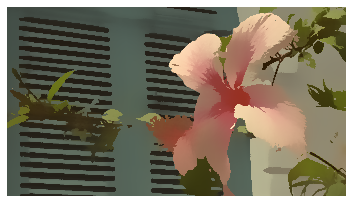

Size : (189, 339, 3)
dtype : uint8
max: 253  min: 4


In [ ]:
flowerImage = ImageProcessor(flower)
flowerImage.filter(SIGMA_SP, SIGMA_RGB, BAND_SIZE, ITER,IMG_UPD_SIZE)
plot_color(flowerImage.filtered)

Iteration 11
Labels :  [ 0  1  2 ... 52 78  0]
CPU times: user 18.3 s, sys: 710 ms, total: 19 s
Wall time: 18.4 s


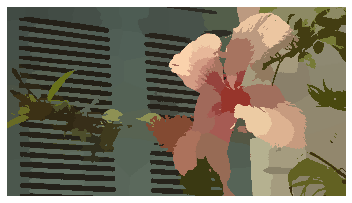

Size : (189, 339, 3)
dtype : uint8
max: 250  min: 15


In [ ]:
import sys
%time flowerImage.cluster(100,10)
plot_color(flowerImage.output_cluster)

Iteration  0 :



converged: 65134  diverged: 138  average_shifts: 6.211778794485215


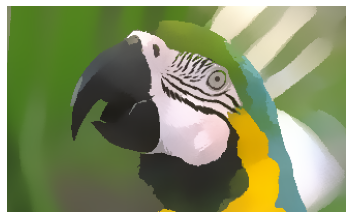

Size : (199, 328, 3)
dtype : uint8
max: 254  min: 0


In [ ]:
parrotImage = ImageProcessor(parrot)
parrotImage.filter(SIGMA_SP, SIGMA_RGB, BAND_SIZE, ITER,IMG_UPD_SIZE)
plot_color(parrotImage.filtered)


Iteration 11
Labels :  [ 0 87  2 ... 92 68 81]
CPU times: user 18.6 s, sys: 687 ms, total: 19.3 s
Wall time: 18.5 s


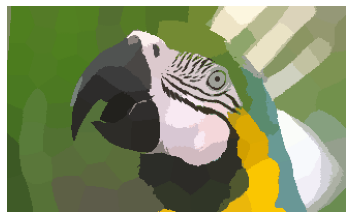

Size : (199, 328, 3)
dtype : uint8
max: 252  min: 0


In [ ]:
%time parrotImage.cluster(100,10)
plot_color(parrotImage.output_cluster)

**Results:**

> Labels assigned to pixels are printed out in the cluster step.


> Total exec time of the program in colab : around 2:30 mins


> Opted to write this program without meshgrid and used np functions to parallely execute rows of operation.



> Parameter values (sigma_sp,sigma_rgb..) were chosen through experimentation.







